In [ ]:
!pip install fair-esm

import torch
import esm
import pandas as pd
import numpy as np
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from copy import deepcopy
from sklearn.model_selection import train_test_split
from scipy.stats import spearmanr

# 1. Initial Setup and Data Loading
with open('sequence.fasta', 'r') as f:
    data = f.readlines()
sequence_wt = data[1].strip()

def get_mutated_sequence(mut, sequence_wt):
    wt, pos, mt = mut[0], int(mut[1:-1]), mut[-1]
    sequence = deepcopy(sequence_wt)
    return sequence[:pos] + mt + sequence[pos + 1:]

df_train = pd.read_csv('train.csv')
df_test = pd.read_csv('test.csv')

df_train['sequence'] = df_train.mutant.apply(lambda x: get_mutated_sequence(x, sequence_wt))
df_test['sequence'] = df_test.mutant.apply(lambda x: get_mutated_sequence(x, sequence_wt))

# 2. Model Preparation
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_esm, alphabet_esm = esm.pretrained.esm2_t33_650M_UR50D()
model_esm = model_esm.to(device).eval().requires_grad_(False)
batch_converter = alphabet_esm.get_batch_converter()

class ProteinDataset(Dataset):
    def __init__(self, df, targets=None):
        self.df = df
        self.targets = targets

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        sequence = self.df.iloc[idx]['sequence']
        if self.targets is not None:
            target = self.targets[idx]
            return sequence, target
        return sequence

class EmbeddingDataset(Dataset):
    def __init__(self, embeddings, targets):
        self.embeddings = embeddings
        self.targets = targets

    def __len__(self):
        return len(self.embeddings)

    def __getitem__(self, idx):
        return self.embeddings[idx], self.targets[idx]

def extract_embeddings(sequences, batch_size=12):
    embeddings = []
    for i in range(0, len(sequences), batch_size):
        batch = sequences[i:i+batch_size]
        _, _, batch_tokens = batch_converter(batch)
        batch_tokens = batch_tokens.to(device)
        with torch.no_grad(), torch.amp.autocast(device_type=device.type):
            results = model_esm(batch_tokens, repr_layers=[33])
        token_representations = results["representations"][33].cpu()
        for j, tokens_len in enumerate((batch_tokens != alphabet_esm.padding_idx).sum(1)):
            embedding_avg = token_representations[j, 1:tokens_len-1].mean(0)
            embeddings.append(embedding_avg.numpy())
        del results, batch_tokens
        torch.cuda.empty_cache()
    return np.array(embeddings)

class FitnessPredictor(nn.Module):
    def __init__(self, input_dim):
        super(FitnessPredictor, self).__init__()
        self.fc1 = nn.Linear(input_dim, 256)
        self.bn1 = nn.BatchNorm1d(256)
        self.dropout1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(256, 128)
        self.bn2 = nn.BatchNorm1d(128)
        self.dropout2 = nn.Dropout(0.4)
        self.fc3 = nn.Linear(128, 64)
        self.bn3 = nn.BatchNorm1d(64)
        self.dropout3 = nn.Dropout(0.3)
        self.fc4 = nn.Linear(64, 1)

    def forward(self, x):
        x = F.leaky_relu(self.dropout1(self.bn1(self.fc1(x))))
        x = F.leaky_relu(self.dropout2(self.bn2(self.fc2(x))))
        x = F.leaky_relu(self.dropout3(self.bn3(self.fc3(x))))
        return self.fc4(x)

# 3. Initial Training
train_targets = df_train['DMS_score'].values.astype(np.float32)
train_dataset = ProteinDataset(df_train, train_targets)
train_indices, val_indices = train_test_split(range(len(train_dataset)), test_size=0.1, random_state=42)
train_encodings = [train_dataset[i][0] for i in train_indices]
train_targets = [train_dataset[i][1] for i in train_indices]
val_encodings = [train_dataset[i][0] for i in val_indices]
val_targets = [train_dataset[i][1] for i in val_indices]

train_encodings_with_ids = [(f"protein_{i}", seq) for i, seq in enumerate(train_encodings)]
train_embeddings = extract_embeddings(train_encodings_with_ids)
input_dim = train_embeddings.shape[1]

fitness_model = FitnessPredictor(input_dim).to(device)
criterion = nn.MSELoss().to(device)
optimizer = optim.Adam(fitness_model.parameters(), lr=0.0015, weight_decay=1e-4)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.75, patience=5, verbose=True)

train_loader = DataLoader(EmbeddingDataset(train_embeddings, train_targets), batch_size=256, shuffle=True, pin_memory=True)
val_encodings_with_ids = [(f"protein_{i}", seq) for i, seq in enumerate(val_encodings)]
val_embeddings = extract_embeddings(val_encodings_with_ids)
val_loader = DataLoader(EmbeddingDataset(val_embeddings, val_targets), batch_size=512, pin_memory=True)

def train_model(model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=150):
    best_val_loss = float('inf')
    patience_counter = 0
    patience = 25
    best_model_state_dict = None
    df_train['sequence'] = df_train['sequence'].fillna("").astype("string")
    df_test['sequence'] = df_test['sequence'].fillna("").astype("string")

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        for batch_x, batch_y in train_loader:
            batch_x, batch_y = batch_x.to(device), batch_y.to(device)
            optimizer.zero_grad()
            with torch.amp.autocast(device_type=device.type):
                outputs = model(batch_x)
                loss = criterion(outputs.squeeze(), batch_y)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
        train_loss /= len(train_loader)

        model.eval()
        val_loss = 0
        with torch.no_grad(), torch.amp.autocast(device_type=device.type):
            for batch_x, batch_y in val_loader:
                batch_x, batch_y = batch_x.to(device), batch_y.to(device)
                outputs = model(batch_x)
                val_loss += criterion(outputs.squeeze(), batch_y).item()
        val_loss /= len(val_loader)
        print(f"Epoch {epoch + 1}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}")

        scheduler.step(val_loss)

        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0
            best_model_state_dict = deepcopy(model.state_dict())
        else:
            patience_counter += 1
        if patience_counter >= patience:
            print(f"Early stopping triggered at epoch {epoch + 1}")
            break

    model.load_state_dict(best_model_state_dict)

train_model(fitness_model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=50)

# 4. Active Learning Loop
def acquisition_function(model, unlabeled_embeddings):
    model.eval()
    with torch.no_grad():
        predictions = model(torch.FloatTensor(unlabeled_embeddings).to(device))
        uncertainties = torch.abs(predictions - 0.5).squeeze().cpu().numpy()
    return uncertainties

def select_samples(model, unlabeled_pool, n_samples=100):
    uncertainties = acquisition_function(model, unlabeled_pool)
    selected_indices = np.argsort(uncertainties)[-n_samples:]
    return selected_indices

def generate_query(model, test_set, n_queries=100):
    test_encodings = [(f"protein_{i}", seq) for i, seq in enumerate(test_set['sequence'])]
    test_embeddings = extract_embeddings(test_encodings)
    selected_indices = select_samples(model, test_embeddings, n_queries)
    selected_mutations = test_set.iloc[selected_indices]['mutant'].tolist()

    with open('query.txt', 'w') as f:
        for mutation in selected_mutations:
            f.write(f"{mutation}\n")

    return selected_mutations

print("Generating query...")
selected_mutations = generate_query(fitness_model, df_test)

#input("Press Enter when the DMS data for the submitted query points...")

# Load the new DMS scores (assuming they are in new_dms_data.csv)
new_data = pd.read_csv('new_dms_data.csv')

# Update training data
df_train = pd.concat([df_train, new_data])
train_encodings = df_train['sequence'].tolist()
train_targets = df_train['DMS_score'].values.astype(np.float32)

# Retrain model
train_encodings_with_ids = [(f"protein_{i}", seq) for i, seq in enumerate(train_encodings)]
train_embeddings = extract_embeddings(train_encodings_with_ids)
train_loader = DataLoader(EmbeddingDataset(train_embeddings, train_targets), batch_size=128, shuffle=True)

train_model(fitness_model, train_loader, val_loader, optimizer, criterion, scheduler, num_epochs=150)

print("Active Learning Query Complete.")

# Final evaluation
test_encodings = [(f"protein_{i}", seq) for i, seq in enumerate(df_test['sequence'])]
test_embeddings = extract_embeddings(test_encodings)
X_test_tensor = torch.FloatTensor(test_embeddings).to(device)
fitness_model.eval()

with torch.no_grad():
    test_predictions = fitness_model(X_test_tensor).cpu().numpy()

matching_mutants = new_data['mutant'].isin(df_test['mutant'])
new_data_aligned = new_data[matching_mutants]

# Get indices of matching mutants in df_test
matching_indices = [df_test['mutant'].tolist().index(mutation) for mutation in new_data_aligned['mutant'].tolist()]

# Select corresponding predictions
aligned_predictions = test_predictions[matching_indices]

# Calculate Spearman's correlation
if len(new_data_aligned['DMS_score']) == len(aligned_predictions):
    corr, p_value = spearmanr(new_data_aligned['DMS_score'], aligned_predictions)
    print(f"Spearman's correlation coefficient: {corr:.4f}")
    print(f"P-value: {p_value}")
else:
    print("DataFrames must have the same number of rows for correlation.")

df_predictions = pd.DataFrame({
    'mutant': df_test['mutant'],
    'DMS_score_predicted': test_predictions.squeeze()
})
df_predictions.to_csv('predictions.csv', index=False)

top10_mutations = df_predictions.nlargest(10, 'DMS_score_predicted')['mutant'].tolist()
with open('top10.txt', 'w') as f:
    for mutation in top10_mutations:
        f.write(f"{mutation}\n")

print("Generated predictions.csv and top10.txt")

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Train Loss=0.3497, Val Loss=0.1732
Epoch 2: Train Loss=0.3503, Val Loss=0.1506
Epoch 3: Train Loss=0.2009, Val Loss=0.1255
Epoch 4: Train Loss=0.1518, Val Loss=0.1022
Epoch 5: Train Loss=0.1305, Val Loss=0.0784
Epoch 6: Train Loss=0.1385, Val Loss=0.0749
Epoch 7: Train Loss=0.1670, Val Loss=0.0568
Epoch 8: Train Loss=0.0893, Val Loss=0.0514
Epoch 9: Train Loss=0.1628, Val Loss=0.0504
Epoch 10: Train Loss=0.0963, Val Loss=0.0510
Epoch 11: Train Loss=0.1058, Val Loss=0.0558
Epoch 12: Train Loss=0.0890, Val Loss=0.0550
Epoch 13: Train Loss=0.0736, Val Loss=0.0530
Epoch 14: Train Loss=0.1216, Val Loss=0.0551
Epoch 15: Train Loss=0.1350, Val Loss=0.0518
Epoch 16: Train Loss=0.0546, Val Loss=0.0503
Epoch 17: Train Loss=0.0592, Val Loss=0.0508
Epoch 18: Train Loss=0.0947, Val Loss=0.0506
Epoch 19: Train Loss=0.0632, Val Loss=0.0499
Epoch 20: Train Loss=0.1091, Val Loss=0.0493
Epoch 21: Train Loss=0.0633, Val Loss=0.0497
Epoch 22: Train Loss=0.0952, Val Loss=0.0495
Epoch 23: Train Los

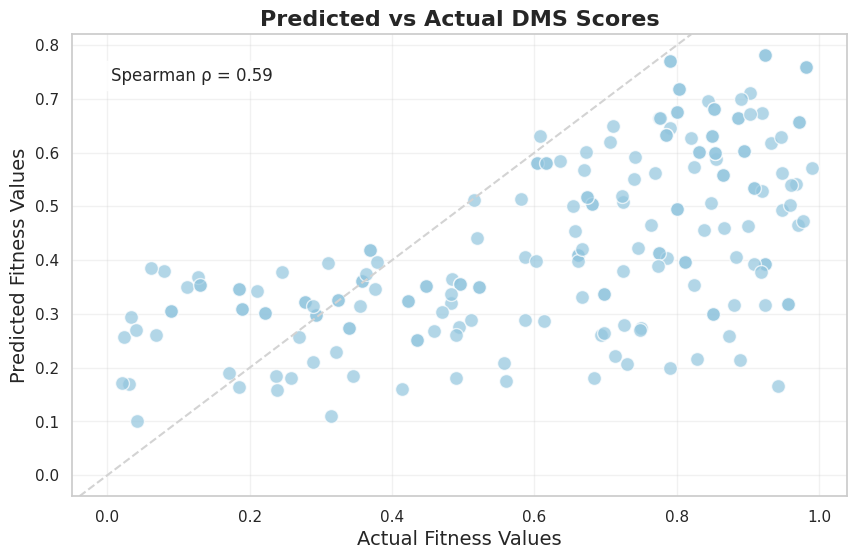

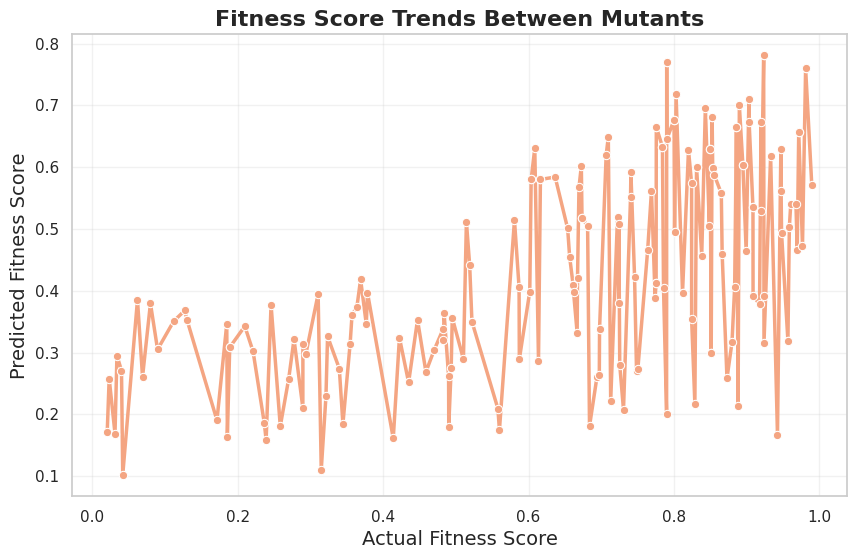

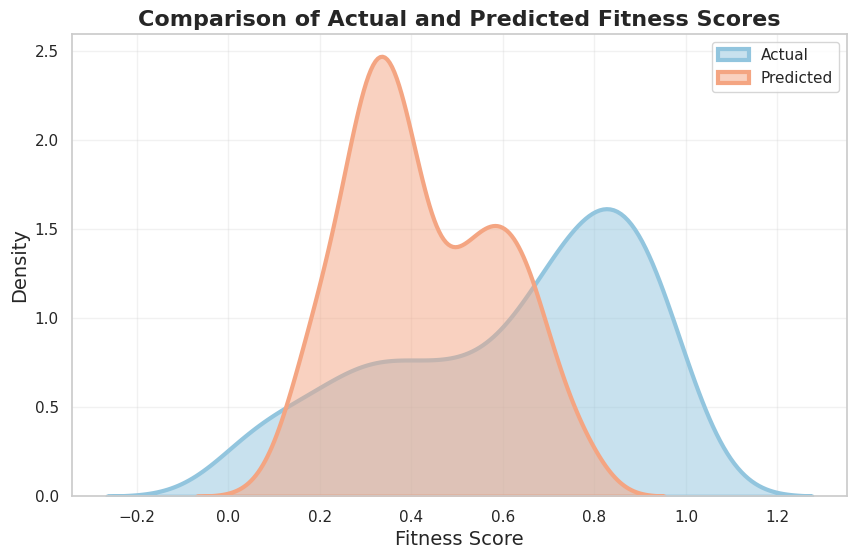

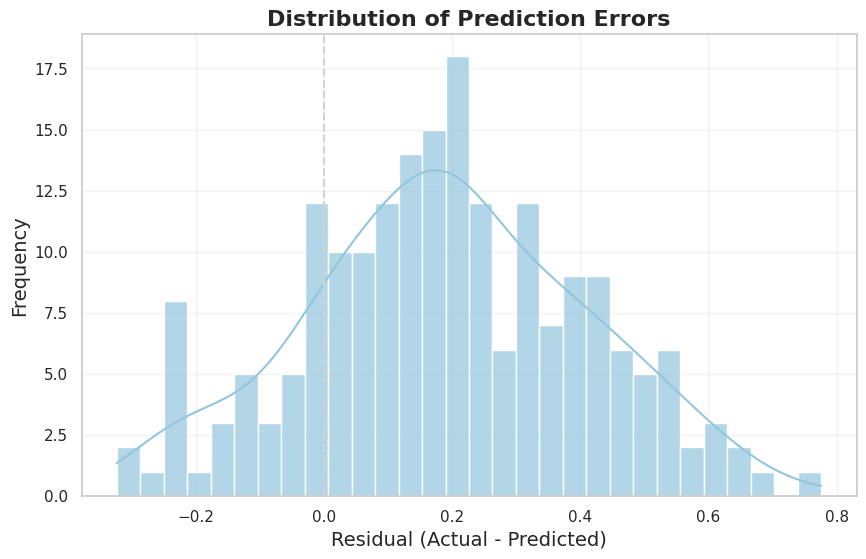

In [ ]:
# Import necessary libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Set a pastel theme
sns.set_theme(style="whitegrid", palette="pastel")

# Define pastel colors
actual_color = "#C3A2D0"  # Soft lavender
predicted_color = "#f4a582"  # Soft coral
grid_color = "#d3d3d3"  # Light gray

# 1. Scatter Plot with Diagonal (Predicted vs Actual)
plt.figure(figsize=(10, 6))
plt.scatter(new_data_aligned['DMS_score'], aligned_predictions,
            alpha=0.7, edgecolors='white', s=100, color=actual_color)
plt.axline((0,0), slope=1, color=grid_color, ls='--', lw=1.5)  # Diagonal line
plt.xlabel('Actual Fitness Values', fontsize=14)
plt.ylabel('Predicted Fitness Values', fontsize=14)
plt.title('Predicted vs Actual DMS Scores', fontsize=16, fontweight='bold')
plt.grid(color=grid_color, alpha=0.3)

# Add Spearman correlation annotation
plt.annotate(f'Spearman ρ = {corr:.2f}',
             xy=(0.05, 0.9), xycoords='axes fraction',
             fontsize=12, bbox=dict(facecolor='white', alpha=0.8))
plt.show()

# 2. Line Plot: Fitness Score Change Between Mutants
# Helps you see if the model correctly captures relative fitness differences rather than absolute values.
aligned_predictions = aligned_predictions.squeeze()

plt.figure(figsize=(10, 6))
sns.lineplot(x=new_data["DMS_score"], y=aligned_predictions, marker="o",
             color=predicted_color, linewidth=2.5)
plt.xlabel("Actual Fitness Score", fontsize=14)
plt.ylabel("Predicted Fitness Score", fontsize=14)
plt.title("Fitness Score Trends Between Mutants", fontsize=16, fontweight='bold')
plt.grid(color=grid_color, alpha=0.3)
plt.show()

# 3. KDE Plot: Fitness Score Distribution
# If the distributions are very different, your model may be biased toward certain score ranges.
plt.figure(figsize=(10, 6))
sns.kdeplot(new_data["DMS_score"], label="Actual", color=actual_color, lw=3, fill=True, alpha=0.5)
sns.kdeplot(aligned_predictions, label="Predicted", color=predicted_color, lw=3, fill=True, alpha=0.5)
plt.xlabel("Fitness Score", fontsize=14)
plt.ylabel("Density", fontsize=14)
plt.title("Comparison of Actual and Predicted Fitness Scores", fontsize=16, fontweight='bold')
plt.legend()
plt.grid(color=grid_color, alpha=0.3)
plt.show()

# 4. Residual Plot: Errors in Prediction
#Helps you see if the model systematically over- or under-predicts fitness scores.
residuals = new_data["DMS_score"] - aligned_predictions

plt.figure(figsize=(10, 6))
sns.histplot(residuals, bins=30, kde=True, color=actual_color, alpha=0.7)
plt.axvline(0, color=grid_color, linestyle='--', lw=1.5)
plt.xlabel("Residual (Actual - Predicted)", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.title("Distribution of Prediction Errors", fontsize=16, fontweight='bold')
plt.grid(color=grid_color, alpha=0.3)
plt.show()
